# Project - COVID-19 New Jersey Trends & Impact on RideSharing Platform

In [48]:
import pandas as pd
# import the seaborn module
import seaborn as sns
import matplotlib.pyplot as plt
import datetime  as dt
import numpy as np
from matplotlib.ticker import PercentFormatter
import os
import missingno as msno # visualize the distribution of NaN values
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly
from datetime import datetime
import dexplot as dxp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import plotly.graph_objects
# from plotly.subplots import make_subplots

#### COVID-19 Dataset --> We have taken New Jersey covid19 data
source --> 
https://covidtracking.com/api/v1/states/daily.csv

#### X Dataset --> We are trying to observe the impact of COVID-19 on the stock prices of major Ridesharing Players (Uber + Lyft)
Source -->
https://finance.yahoo.com/quote/UBER/history?p=UBER

https://finance.yahoo.com/quote/LYFT/history?p=LYFT

Project Git Repository --> https://github.com/marif1901/COVID19_NJ_ImpactAnalysis

## Part 1: Data Pre Processing (10%)

In [2]:
cov_url= 'https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/COVID19_Data_NJ.csv'
x_uber_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/UBER_1Y.csv"
x_lyft_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/LYFT_1Y.csv"


###### Reading Datasets

In [3]:
covid = pd.read_csv(cov_url,sep=',')# use sep="," for coma separation. 
xuber = pd.read_csv(x_uber_url,sep=',')
xlyft = pd.read_csv(x_lyft_url,sep=',')
print(covid.columns)
print(xuber.columns)
print(xlyft.columns)

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'death', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease', 'dailypositvecases', 'dailynegativecases',
       'dailytestingdone', 'dailydeath'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


###### Preprocessing on COVID Data

In [4]:
covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'positive', 'negative', 'death','totalTestResults']
covid_sel= covid[covid_cols].copy()

covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']

covid_sel.columns=  covid_cols

###### Dropping rows where data is NA

In [5]:
sum(pd.isna(covid_sel['date']))
index = covid_sel[pd.isna(covid_sel['date'])].index
covid_sel.drop(index , inplace=True)

###### Converting date to proper %Y%m%d format

In [6]:
covid_sel['date']= covid_sel['date'].astype(str)
covid_sel['date'] = pd.to_datetime(covid_sel['date'], format='%Y%m%d').dt.strftime("%Y-%m-%d");


In [7]:
int_col= ['dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']
covid_sel[int_col] = covid_sel[int_col].convert_objects(convert_numeric=True)
covid_sel.head()

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults
0,2020-04-26,3515,5943,75,9458,3515,5943,75,9458,109038,114106,5938,223144
1,2020-04-25,3327,4397,246,7724,3327,4397,246,7724,105523,108163,5863,213686
2,2020-04-24,2207,3607,249,5814,2207,3607,249,5814,102196,103766,5617,205962
3,2020-04-23,4124,4365,305,8489,4124,4365,305,8489,99989,100159,5368,200148
4,2020-04-22,3478,3355,310,6833,3478,3355,310,6833,95865,95794,5063,191659


In [8]:
print('Min Date observed for COVID : ' + str(covid_sel['date'].min()))
print('Max Date observed for COVID: ' + str(covid_sel['date'].max()))

Min Date observed for COVID : 2020-03-05
Max Date observed for COVID: 2020-04-26


###### Preprocessing on X Data

In [9]:
x_cols= ['Date','Close','Volume']

xuber_sel= xuber[x_cols].copy()
xlyft_sel= xlyft[x_cols].copy()

x_cols= ['date','UberClosingPrice','UberVolume']
xuber_sel.columns= x_cols

x_cols= ['date','LyftClosingPrice','LyftVolume']
xlyft_sel.columns=x_cols

In [10]:
xuber_sel.date= pd.to_datetime(xuber_sel['date']).dt.strftime('%Y-%m-%d')
xlyft_sel.date=pd.to_datetime(xlyft_sel['date']).dt.strftime('%Y-%m-%d')

In [12]:
x_sel= pd.merge(xuber_sel, xlyft_sel,on='date')
print('\033[1m' + 'Min Date observed for X : ' + str(x_sel['date'].min()))
print('\033[1m' + 'Max Date observed for X: ' + str(x_sel['date'].max()))

Min Date observed for X : 2019-05-10
Max Date observed for X: 2020-04-24


In [13]:
x_sel.head()

,date,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
0,2019-05-10,41.570000,186322500,51.090000,23111200
1,2019-05-13,37.099998,79442400,48.150002,10007400
2,2019-05-14,39.959999,46661100,50.520000,7007400
3,2019-05-15,41.290001,36086100,54.040001,7909300
4,2019-05-16,43.000000,38115500,55.599998,7101700


###### Merging COVID data with X Data for Analysing impact in the same time frame

In [15]:
comb_df= covid_sel.merge(x_sel, how='inner', on='date')
comb_df=comb_df.drop_duplicates()
print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))

Min Date observed for comb_df : 2020-03-05
Max Date observed for comb_df: 2020-04-24


###### Filtering 4 weeks timeframe for Analysis

In [16]:

st_dt= pd.to_datetime('2020-03-23').strftime('%Y-%m-%d')
print(st_dt)
end_dt= pd.to_datetime('2020-04-19').strftime('%Y-%m-%d')
print(end_dt)

comb_df = comb_df[ (comb_df['date']>=st_dt) & (comb_df['date']<=end_dt)] 

print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))

comb_df.head()

2020-03-23
2020-04-19
Min Date observed for comb_df : 2020-03-23
Max Date observed for comb_df: 2020-04-17


,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
5,2020-04-17,3150,2469,322,5619,3150,2469,322,5619,78467,78982,3840,157449,28.000000,34129800,29.070000,8437400
6,2020-04-16,4287,3522,362,7809,4287,3522,362,7809,75317,76513,3518,151830,27.030001,24088700,27.139999,6881400
7,2020-04-15,2206,2041,351,4247,2206,2041,351,4247,71030,72991,3156,144021,27.410000,18720900,28.389999,6825200
8,2020-04-14,4240,6065,362,10305,4240,6065,362,10305,68824,70950,2805,139774,27.750000,32625300,30.500000,5713400
9,2020-04-13,2734,0,93,2734,2734,0,93,2734,64584,64885,2443,129469,27.990000,24671600,30.660000,6697400


###### Assigning Week Number

In [17]:
comb_df['WeekNum'] = ((pd.to_datetime(comb_df['date']) - pd.to_datetime(st_dt)).dt.days)//7 +1
# weeklycount=comb_df['WeekNum'].value_counts()
# weeklycount

###### Checking Nullity and Data Completeness

Text(0.5, 1.0, 'Data Completenss Check for Combined data')

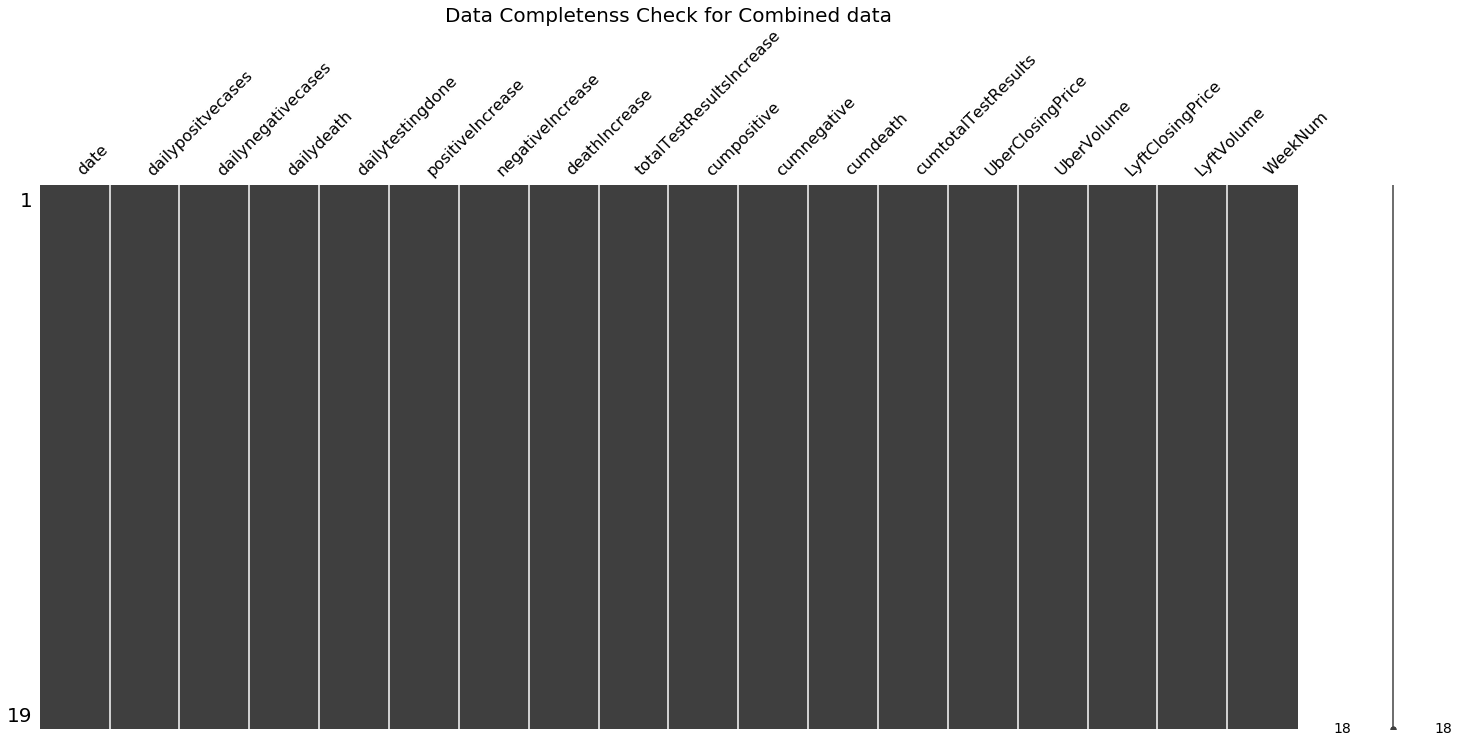

In [20]:
msno.matrix(comb_df)
plt.title('Data Completenss Check for Combined data', size = 20)

# msno.bar(comb_df)
# plt.title('Visualization of Nullity by column for Combined data', size = 10)

###### No Nullity found above

In [21]:
comb_df= comb_df.sort_values(by="date")

## Part 2: General Trends in Covid + X Data (10%)

###### PDF and CDF of COVID 19 Growth

In [26]:
comb_df.head(3)

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume,WeekNum
23,2020-03-23,930,32,7,962,930,32,7,962,2844,359,27,3203,22.400000,47787100,22.610001,10885100,1
22,2020-03-24,831,7966,17,8797,831,7966,17,8797,3675,8325,44,12000,26.389999,58505000,27.059999,12634400,1
21,2020-03-25,727,2127,18,2854,727,2127,18,2854,4402,10452,62,14854,26.190001,52473900,27.950001,14107700,1


In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailypositvecases'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailydeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailynegativecases'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = '[Daily Cases] - Confirmed, Deaths & Negative'
        #yaxis_type="log"
    )
fig.show()

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumpositive'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumdeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumnegative'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Cumulative -> Confirmed, Deaths & Negative Results'
#         title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
        #yaxis_type="log"
    )
fig.show()

In [111]:
df_t= comb_df.copy()
df_t['Positive Rate'] = df_t['cumpositive']/df_t['cumtotalTestResults']
df_t['Negative Rate'] = df_t['cumnegative']/df_t['cumtotalTestResults']

df_t['Death Rate'] = df_t['cumdeath']/df_t['cumpositive']



fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Positive Rate'], 
                         mode='lines+markers', name='Positive Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Negative Rate'], 
                         mode='lines+markers', name='Negative Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Death Rate'], 
                         mode='lines+markers', name='Death Rate'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Confirmed Rate, Negative Rate & Death Rate'
#         yaxis_type="log"
    )
fig.show()


In [104]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['LyftVolume'], 
                         mode='lines+markers', name='LyftVolume'))

fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['UberVolume'], 
                         mode='lines+markers', name='UberVolume'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'COVID19 Impacts on -> LyftVolume & UberVolume'
#         title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
#         yaxis_type="log"
    )
fig.show()


In [146]:
df_temp= comb_df.copy()
df_temp['Uber_pctChange'] = df_temp['UberClosingPrice'].pct_change(periods=1)
df_temp['Lyft_pctChange'] = df_temp['LyftClosingPrice'].pct_change(periods=1)
df_temp['Positive_pctChange'] = df_temp['cumdeath'].pct_change(periods=1)
df_temp = df_temp.iloc[1:]
# df_temp.head()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Positive_pctChange'], 
                         mode='lines+markers', name='Positive_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Uber_pctChange'], 
                         mode='lines+markers', name='Uber_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Lyft_pctChange'], 
                         mode='lines+markers', name='Lyft_pctChange'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Velocity of -> Confirmed Cases , LyftClosingPrice & UberClosingPrice'
#         title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
#         yaxis_type="log"
    )
fig.show()

# from scipy.stats import pearsonr,spearmanr
# corr, _ = pearsonr(df_temp['Positive_pctChange'], df_temp['Uber_pctChange'])
# print('\033[1m' + 'Correlation of Rate of change in Postive cases v/s Rate of change in Ubers Stocks Value: %.3f' % corr)

# corr, _ = pearsonr(df_temp['Positive_pctChange'], df_temp['Lyft_pctChange'])
# print('\033[1m' + 'Correlation of Rate of change in Postive cases v/s Rate of change in Lyfts Stocks Value: %.3f' % corr)




###### Inference from above graph: As the velocity in the Positive Cases increases we see that velocity in the Uber Lyft Price decreases and when the velocity of confirm cases decreases then velocity in the Stock Prices of Uber Lyft Increases

In [83]:
df_temp=comb_df.copy()
df_temp['Country_Region']= 'NJ'
df_temp['Lat']= 39.833851
df_temp['Long']= -74.871826

df_temp = df_temp.groupby(['date', 'Country_Region','Lat','Long'])['cumpositive', 'cumdeath'].max().reset_index()
df_temp["date"] = pd.to_datetime(df_temp["date"]).dt.strftime('%m/%d/%Y')
df_temp.columns=['Last_Update','Country_Region','Lat','Long','Confirmed','Deaths']
df_temp['Confirmed'].fillna(0, inplace=True)
df_temp.sort_values('Confirmed', ascending=False).head()

,Last_Update,Country_Region,Lat,Long,Confirmed,Deaths
18,04/17/2020,NJ,39.833851,-74.871826,78467,3840
17,04/16/2020,NJ,39.833851,-74.871826,75317,3518
16,04/15/2020,NJ,39.833851,-74.871826,71030,3156
15,04/14/2020,NJ,39.833851,-74.871826,68824,2805
14,04/13/2020,NJ,39.833851,-74.871826,64584,2443


In [84]:
fig = px.scatter_geo(df_temp,
                     #locations="Country_Region",
                     locationmode='country names',
                     lat='Lat', lon='Long',
                     #hover_name="Country_Region",
                     hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                     color=np.log10(df_temp["Confirmed"]+1)-1, size=np.power(df_temp["Confirmed"]+1, 0.3)-1,
                     range_color= [0, max(np.log10(df_temp["Confirmed"]+1))],
                     title="COVID-19 Progression Animation Over Time",
                     color_continuous_scale=px.colors.sequential.Plasma,
                     projection="natural earth"
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
#fig.update_coloraxes(colorbar_title="Color (Confirmed Cases Log Scale)")
fig.show()

In [86]:
fig = px.choropleth(df_temp,
                    locations="Country_Region",
                    locationmode="USA-states",
                    #lat='Lat', lon='Long',
                    hover_name="Country_Region",
                    hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                    color=np.log10(df_temp["Confirmed"]), 
                     
                    title="COVID-19 Progression Animation in New Jersey Over Time",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope="usa",
                   )
fig.update(layout_coloraxis_showscale=False)
fig.show()


## Part 3: Required Inferences (50%)

### 3.1 Predicting the COVID19 fatality & #cases over next one week

#### 3.1.1 AR(3)

#### 3.1.2 AR(5)

#### 3.1.3 EWMA with alpha = 0.5

#### 3.1.4 EWMA with alpha = 0.8

### 3.2 Apply the Wald’s test, Z-test, and t-test to check whether the mean of COVID19 deaths and #cases are different from the first week to the last week

#### 3.2.1 Use MLE for Wald’s test as the estimator

#### 3.2.2 Two-sample version of Wald and t-tests

#### 3.2.3 Z-test

### 3.3 Equality of distributions (distribution of first week and last week), using K-S test and Permutation test

#### 3.3.1 K-S Test

#### 3.3.2 Permutation Test

### 3.4 Pearson correlation for #deaths and Stock Prices,  #cases and Stock Prices


In [129]:
import math
def p_coeff(a,b):

    ab_n1 = 0 
    ab_d1 = 0 
    ab_d2 = 0

    mean_a = sum(a)/len(a)
    mean_b = sum(b)/len(b)
    for i, j in zip(a,b):
        ab_n1 += (i- mean_a) * (j- mean_b)
        ab_d1 += (i- mean_a) * (i- mean_a)
        ab_d2 += (j- mean_b) * (j- mean_b)
    ab = ab_n1 / (math.sqrt(ab_d1) * math.sqrt(ab_d2))
    return ab

#### 3.4.1 Pearson correlation for #deaths and Stock Price

In [130]:
corr= p_coeff(comb_df['cumdeath'], comb_df['UberVolume'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Uber: %.3f' % corr)

corr = p_coeff(comb_df['cumdeath'], comb_df['LyftVolume'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #deaths and Stock Price of Uber: -0.769
Pearsons correlation of #deaths and Stock Price of Lyft: -0.502


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the Deaths, this means that increase in #deaths day on day has adversely affected ride sharing company with less people moving out

#### 3.4.2 Pearson correlation for #cases and Stock Price

In [131]:
corr= p_coeff(comb_df['cumpositive'], comb_df['UberVolume'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Uber: %.3f' % corr)

corr= p_coeff(comb_df['cumpositive'], comb_df['LyftVolume'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #Confirmed Cases and Stock Price of Uber: -0.829
Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: -0.524


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the #Confirm cases, this means that increase in #Confim cases day on day has brought the city to a halt and ride sharing company stocks are going down as less and less people are moving out

### 3.5 Posterior Distributions for daily deaths parameter estimator 

#### 3.5.1 First week to Second week

#### 3.5.2 Second week to third week

#### 3.5.3 Third week to fourth week

#### 3.5.4 Plot all posterior distributions on one graph

#### 3.5.5 Report the MAP for all posteriors

## Part 4: Creative Inferences (30%)

### Hypothesis1: Due to COVID outbreak Stock prices of Uber+Lyft decreased significantly

#### Inference1: Below are the inference for H1

### Hypothesis2: Due to Uber Lyft being functional Covid Spread Quickly and once they were shut spread went down, pre v/s post lockdown impact on spread

#### Inference2: Below are the inference for H2

### Inference3: linear regression to find the impact on Stock Prices of Uber +Lyft because of the severity of covid19  duration